In [1]:
from qiskit import Aer
from qiskit import IBMQ, assemble, transpile
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import *
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import pandas as pd
import scipy
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import datetime
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import Image

# Finance assistance software

The modern stocks market is a complicated system based on analytics (and insights) and software tools where decision speed is critical. There are many tools, helping professionals with the selection of proper strategies and monitoring different stock parameters. Quantum algorithms can bring advances of near-term quantum devices to the financial domain, as they can deliver the results in a compatible time with classical devices (and outperform them in the future). The goal of this showcase is to become the first step in the creation of advanced analytical tools that can become a part of services provided by the marketplace to customers, or professionals.

Usually, there are few approaches in the analysis of the stock market: manual (private analysts or small companies still run their models in plain Excel and provide a valid result), stock-provided tools (some markets provide the user with tools allowing to see more indicators than prices of stocks in a timeline, example: VaR, CVaR, Moving Average, Trend, Stochastic forecasting results of simulations using different trading strategies, the suggestion of news relevant to specific asset holder, check indicators section for example at [Bitfinex](https://trading.bitfinex.com/t/BTC:USD?demo=true) and software packages interacting with the markets using an API and providing analysis, as well as the commitment (actual trading).

We will focus on the investigation of quantum applications to the modern portfolio theory and then will create the actual software that can become a part of the indicators section for any trading platform or automated trading tool using the APIs. Ideally, this software should work in real-time using the tickers' data and seamlessly provide the indicator or forecast. The application will consist of three parts: API-first application responsible for fetching the required stocks data (server), running different models and respond, and client application interfacing the API to a real user(client), and a Telegram-bot.

API-application will be designed to be a reusable, maintainable, and failure-safe application, agnostic to any interface and built with best practices in terms of caching, security, networking, parallel execution, and more.

The client application will be a simple React-based app designed to show the abilities of the server application. It will have a stock selector, model selector, and results section showing the output of the server app.

Telegram-bot will show another way to interact with the server app, to support it will have to create a webhook endpoint processing the requests of the user and perform the requests to the server application.

### Helper functions

In [15]:
def add_revenue_column(panel_data):
    revenue = [0]
    for x in range(0, len(panel_data['Close']) - 1):
        if (x != 0):
            value = panel_data['Close'][x + 1] - panel_data['Close'][x]
            revenue.append(value)
    revenue.append(0)
    return revenue

def add_revenue_normalized_column(panel_data):
    revenue = np.log(panel_data['Close']/panel_data['Close'].shift(1))
    return revenue

# Plots frequency histogram.
def plot_freq_histogram(revenue, ticker, density):
    rmean = revenue.mean();
    rstd = revenue.std();
    revenue.hist(bins=40, histtype="stepfilled", alpha=0.5, density=density, figsize=(12,8))
    if (density == True):
        x = np.linspace(rmean - 4*rstd, rmean + 4*rstd, 200)
        norm = scipy.stats.norm.pdf(x, rmean, rstd);
        plt.plot(x, norm, "r")
    ylabel = ""
    if density == True:
        ylabel = "Probability"
    else:
        ylabel = "Frequency"
    plt.gca().set(title='Frequency Histogram for ' + ticker, ylabel=ylabel, xlabel='Revenue (USD)')
    plt.axvline(rmean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(rmean + rstd, color='y', linestyle='dashed', linewidth=2, label='σ')
    plt.axvline(rmean - rstd, color='y', linestyle='dashed', linewidth=2, label='-σ')
    plt.axvline(rmean + 2 * rstd, color='m', linestyle='dashed', linewidth=2, label='2σ')
    plt.axvline(rmean - 2 * rstd, color='m', linestyle='dashed', linewidth=2, label='-2σ')
    plt.show()
    
# Fetches the stock data frame data.
def get_stock_dataframe(ticker, density=False):
    start=datetime.datetime(2020, 3, 19)
    end=datetime.datetime(2021, 2, 20)
    # Read data from web.
    panel_data = web.DataReader(ticker, 'yahoo', start, end)
    return panel_data['Close']

In [17]:
aapl_data=get_stock_dataframe(['NFLX', 'AAPL', 'FB', 'GOOG'])
aapl_data.head()

Symbols,NFLX,AAPL,FB,GOOG
Date,,,,
2020-03-19,332.029999,61.195000,153.130005,1115.290039
2020-03-20,332.829987,57.310001,149.729996,1072.319946
2020-03-23,360.269989,56.092499,148.100006,1056.619995
2020-03-24,357.320007,61.720001,160.979996,1134.459961
2020-03-25,342.390015,61.380001,156.210007,1102.489990


### Fetch stock data for N assets

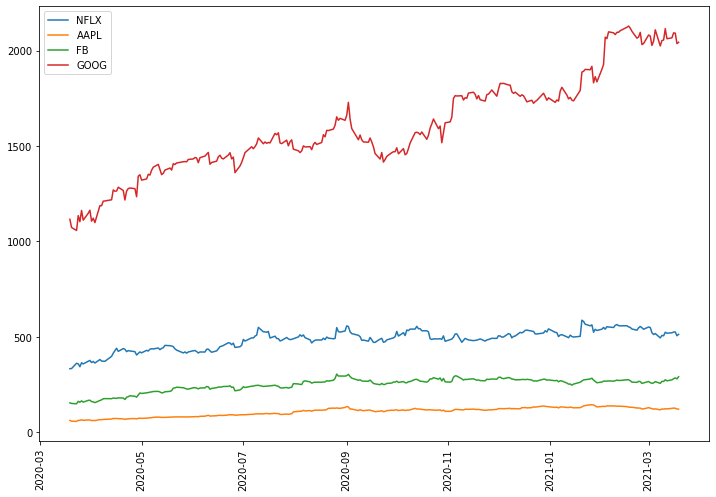

In [9]:
num_assets = 4
tickers = ['NFLX', 'AAPL', 'FB', 'GOOG'];
try:
    data = YahooDataProvider(
                 tickers = tickers,
#                  tickers = ["AAPL", "AMZN"],
#                  tickers = ["AMZN", "AAPL", "CDR", "NOKPF"],
                 
                 start=datetime.datetime(2020, 3, 20),
                 end=datetime.datetime(2021, 3, 20))
    data.run()
    plt.figure(figsize=(12,8))
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex: 
    data = None
    print(ex)

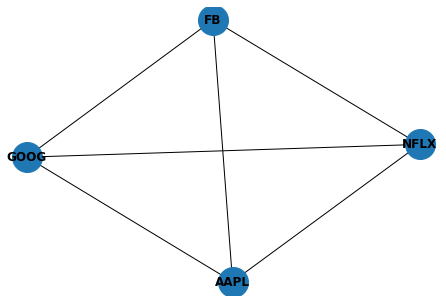

In [5]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(['NFLX', 'AAPL', 'FB', 'GOOG'])
nodes = list(G.nodes)
for x in nodes:
    for y in nodes:
        if (x != y):
            G.add_edge(x, y)
pos = nx.planar_layout(G)
nx.draw(G, with_labels=True, font_weight='bold', node_size=900)

# Modern portfolio theory (Markovitz theory)

### Given
We consider that assets owner has some whole amount of assets *B* (Google, Facebook, Tesla, etc). Each asset **i** is held in different proportion (weight) $w_{i}$ in that way that sum of that assets is **B**.
Each asset generates some return $\mu_i$. MPT allows to optimize the portfolio by finding proper ratio between the risk and return.

### Basic definitions
1. **Expected return.** Amount of money to be gained by the portfolio in general.

$\begin{aligned}
E(\mu_p) = \sum_{i}w_iE(\mu_i)
\end{aligned}$

2. **Volatility** In finances standard deviation $\sigma$ is called volatility, and it determines the risk. If we try to fit the frequency distribution to some probability distribution by given mean and deviation, than we can calculate the VaR or cVaR (n% of loss we are confident to lose).

3. **Variance** Measure of the dispersion of a random value from mathematical expectation. Original work tries to find the minumum for such variance (by using Lagrangian) in presence of different constraints.

$\begin{aligned}
\sigma^2_{p} = \sum_{i}w^2_{i}\sigma^2_{i} + \sum_{i}\sum_{i != j}\sigma_{i}\sigma_{j}\rho_{ij}
\end{aligned}$

and in the matrix form

$\begin{aligned}
\sigma^2_{p} = \sum_{i}\sum_{j}w_{i}w_{j}COV_{ij}
\end{aligned}$

4. **Covariance** Measure of similarity in behavior between two given assets. It's positive if assets behave similarly (one grows if another grows, example: related companies, or some currencies with oil price), or negative if dependency is opposite (one grows, other falls).

$\begin{aligned}
COV(X,Y) = M[(X-MX)(Y-MY)]
\end{aligned}$

5. **Covariance matrix** Square matrix with covariances between every asset.

6. **Correlation** Measure of similarity in behavior between two given assets, but normilized to product of deviations.

### Basic idea
MPT is a mean-variance theory, and it compares the expected (mean) return of a portfolio with the variance of the same portfolio. If variance of the asset is greater than an average return - it's risky asset. Owner can get higher profit, but with a higher value at risk. Example: Mean profit is 10 dollars, but variance is 20 dollars. One can get much more than mean but together with that it can lose profit. Other case is profit expectation is 10 dollars and variance is 8, it means that we do not even go to the risk area and get profit for sure.

If we plot all combination of mean expected returns vs standard deviations for every assets, we may observe the region in this space. Left boundary of this area is parabolic (and upper part of this region is called the **efficiency frontier** in the absence risk-free asset).

The goal of this optimization is to find the point on the frontier a which the inverse of the slope of a frontier would be equal to our risk appetite.


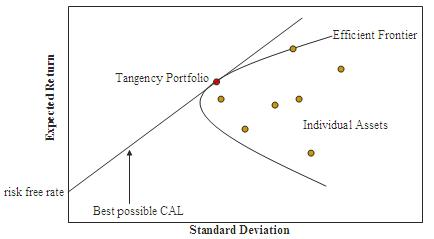

In [94]:
Image(filename = "img/Markowitz_frontier.jpg", width = 600, height = 300)

### Optimization by selecting assets to buy.

General MPT covers the cases of rebalancing the items in the portfolio under different constraints and strategies. We will concentrate on the basic case, when we just select if we want to buy the asset or not (binary decision), and we have to spend the full budget.

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T A x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets, 
- $A \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker, and is an essential parameter for searching the budged in a frontier.
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

#### We can make a variable transformation:

$\begin{aligned}
x_{i} = (1 - z_{i})/2 \text{ to } z_{i} ∈ { -1, +1 }
\end{aligned}$

And cost function can be expressed as Ising spin glass model.

$\begin{aligned}
\min_{z \in \{-1, 1\}^n}  z^T Q z - c^Tz \\
\end{aligned}$

where Q is updated covariance matrix and $c^T$ is updated vector of returns.
With that given we may go to Pauli Z-matrices and all $z_{i}z_{j}$ are expressed as $\sigma^i_{Z} ⊗ \sigma^j_{Z}$ and sum of tensor products of Pauli terms gives us a desired Hamiltonian.

## Closer look to stock data

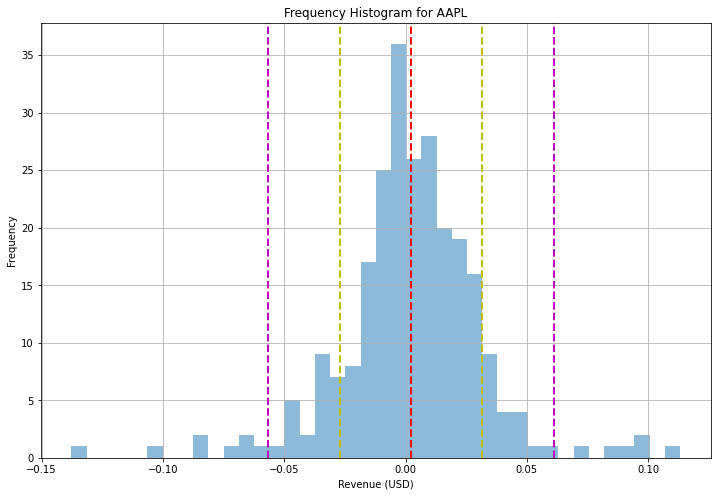

count    252.000000
mean       0.002259
std        0.029440
min       -0.137708
25%       -0.010488
50%        0.001653
75%        0.016930
max        0.113157
Name: Close, dtype: float64


In [349]:
aapl_data=get_stock_dataframe('AAPL')

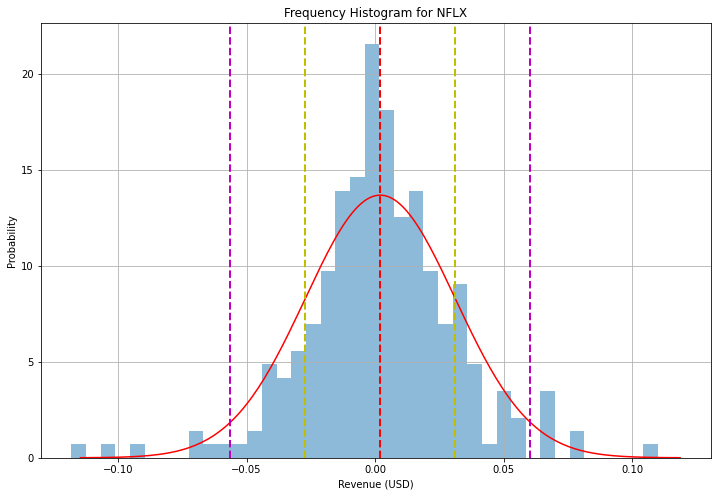

count    252.000000
mean       0.001962
std        0.029139
min       -0.118095
25%       -0.013497
50%        0.001267
75%        0.017500
max        0.109829
Name: Close, dtype: float64


In [350]:
nflx_data=get_stock_dataframe('NFLX', True)

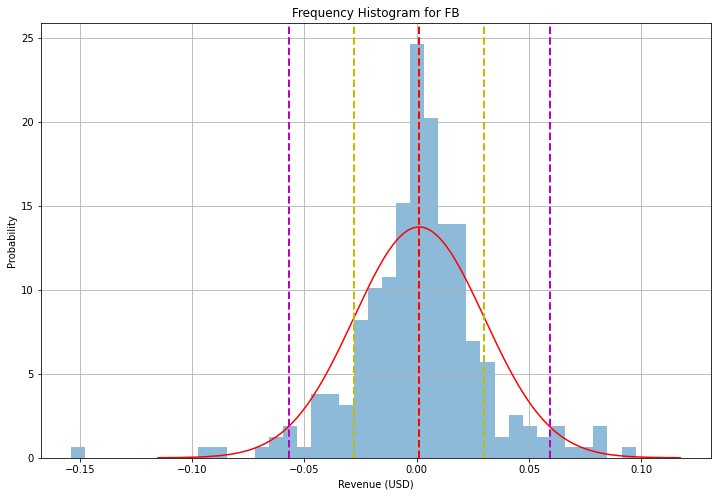

count    252.000000
mean       0.001048
std        0.029049
min       -0.153769
25%       -0.013317
50%        0.002172
75%        0.015202
max        0.097444
Name: Close, dtype: float64


In [351]:
fb_data=get_stock_dataframe('FB', True)

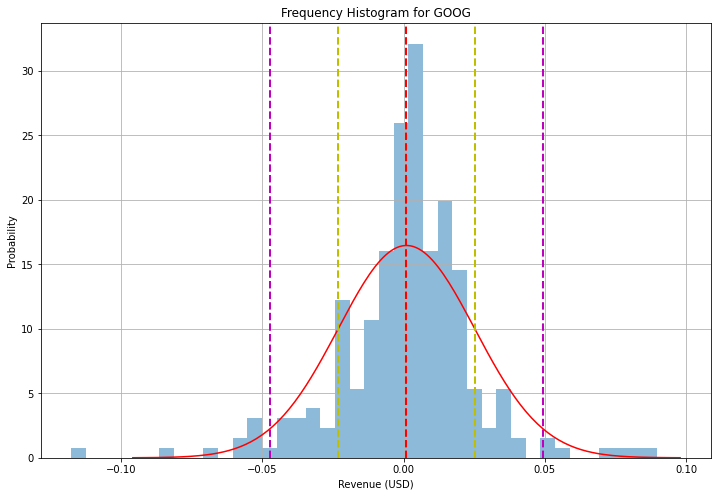

count    252.000000
mean       0.000983
std        0.024225
min       -0.117667
25%       -0.008743
50%        0.003340
75%        0.013685
max        0.089856
Name: Close, dtype: float64


In [352]:
goog_data=get_stock_dataframe('GOOG', True)

## Building efficient frontier in a classical manner using Sharpe ratio.

**Sharpe ratio** is a coefficient describing the value of return without value at risk divided by the standard deviation.

$\begin{aligned}
Sharp_i = \frac{\mu_i - VaR }{\sigma}
\end{aligned}$

In [18]:
# Merge stocks data for the amazon and apple.
### From our stocks data.
stocks = pd.DataFrame.from_dict(data._data).transpose()
stocks.columns = ['NFLX', 'AAPL', 'FB', 'GOOG']
# stocks.columns = ['amzn','aapl', 'ccl', 'nokpf']
stocks.head()

,NFLX,AAPL,FB,GOOG
Date,,,,
2020-03-19,332.029999,60.724293,153.130005,1115.290039
2020-03-20,332.829987,56.869179,149.729996,1072.319946
2020-03-23,360.269989,55.661041,148.100006,1056.619995
2020-03-24,357.320007,61.245258,160.979996,1134.459961
2020-03-25,342.390015,60.907871,156.210007,1102.489990


In [19]:
def monte_carlo(tickers, df, n):
    dailyReturns = df.pct_change()
    annualReturns = dailyReturns.mean() * 253
    dailyCov = dailyReturns.cov()
    annualCov = dailyCov * 253
    np.random.seed(42)
    # Helper variables.
    portfolioReturns = []
    portfolioRisk = []
    stockWeights = []
    for portf in range(n):
        # Creating the weights for the portfolio.
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)

        # Calculate portfolio return.
        returns = np.dot(weights, annualReturns)
        risk = np.sqrt(np.dot(weights.T, np.dot(annualCov, weights)))

        # Save results to the list.
        portfolioReturns.append(returns)
        portfolioRisk.append(risk)
        stockWeights.append(weights)

        portfolio = {'Returns': portfolioReturns, 'Risk': portfolioRisk}
        for idx, tic in enumerate(tickers):
            portfolio[tic+'_Weight'] = [Weight[idx] for Weight in stockWeights]
    pdf = pd.DataFrame(portfolio)
    data=pd.concat([pdf['Returns'], pdf['Risk']], axis=1)
    data['Sharpe'] = pdf['Returns']/pdf['Risk']
    return data

def max_sharpe(data):
    print('Max sharpe ratio in the array: {}'.format(data['Sharpe'].max()))
    print('Its location in the array: {}'.format(data['Sharpe'].argmax()))
    max_sr_ret = data['Returns'][data['Sharpe'].argmax()]
    max_sr_vol = data['Risk'][data['Sharpe'].argmax()]
    return {'return': max_sr_ret, 'volatility': max_sr_vol}

def plot_efficiency(data, sharpe):
    plt.figure(figsize=(12,8))
    plt.title('Markowitz portfolio (Monte-Carlo)')
    plt.scatter(data['Risk'], data['Returns'], c=data['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(sharpe['volatility'], sharpe['return'], c='red', s=50)
    plt.xlabel('Volatility - standard deviation')
    plt.ylabel('Return')
    plt.show()

In [20]:
n = 10000
mc_data = monte_carlo(tickers, stocks, n)
sharpe = max_sharpe(mc_data)

Max sharpe ratio in the array: 2.179082164340157
Its location in the array: 2529


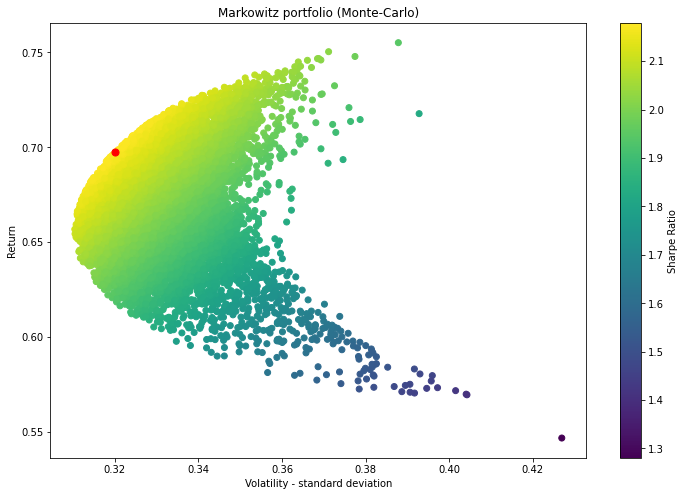

In [21]:
plot_efficiency(mc_data, sharpe)

## Calculate means vector, similarity and covariance matrices

Means:
[ 484.27743108  106.29094692  248.0121741  1602.22843601]
A time-series similarity measure:
[[1.00000000e+00 1.04569061e-05 1.67293711e-05 3.53554776e-06]
 [1.04569061e-05 1.00000000e+00 2.78897470e-05 2.64220210e-06]
 [1.67293711e-05 2.78897470e-05 1.00000000e+00 2.91871341e-06]
 [3.53554776e-06 2.64220210e-06 2.91871341e-06 1.00000000e+00]]


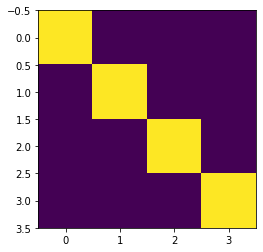

A covariance matrix:
[[ 2626.26969847  1052.82899987  1524.69807305 10673.84276013]
 [ 1052.82899987   518.53862458   724.76474809  5013.8511881 ]
 [ 1524.69807305   724.76474809  1225.05301259  6875.92072593]
 [10673.84276013  5013.8511881   6875.92072593 67033.29212038]]


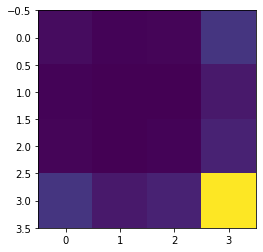

In [22]:
means = data.get_mean_vector()
print("Means:")
print(means)

rho = data.get_similarity_matrix()
print("A time-series similarity measure:")
print(rho)
plt.imshow(rho)
plt.show()

cov = data.get_covariance_matrix()
print("A covariance matrix:")
print(cov)
plt.imshow(cov)
plt.show()

In [23]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
sigma

array([[0.00079307, 0.00031018, 0.00033946, 0.00025658],
       [0.00031018, 0.0006179 , 0.00043981, 0.00032467],
       [0.00033946, 0.00043981, 0.00064367, 0.00038779],
       [0.00025658, 0.00032467, 0.00038779, 0.00044465]])

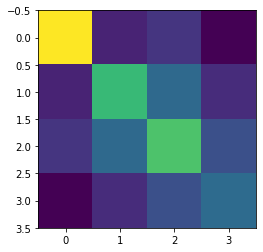

In [24]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [25]:
import itertools
def get_binary_permutations(num_assets):
    return [list(seq) for seq in itertools.product([0, 1], repeat=num_assets)]
perms = get_binary_permutations(num_assets)
perms

[[0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [1, 0, 0, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 0, 1, 1],
 [1, 1, 0, 0],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [1, 1, 1, 1]]

In [26]:
def getRisks(perms, cov):
    output = [];
    for decision in perms:
        x_t = np.array(decision)
        x = np.array([decision]).T
        result = x_t.dot(cov).dot(x)
        output.append(result[0])
    return output

def getReturns(perms, means):
    output = [];
    for decision in perms:
        x = np.array([decision]).T
        result = means.dot(x)
        output.append(result[0])
    return output

risks = getRisks(perms, sigma)
risks

[0.0,
 0.00044464596227325855,
 0.0006436682125011112,
 0.0018639004826647946,
 0.0006179006720148563,
 0.001711888729078744,
 0.0021411973783771014,
 0.0040107717433314136,
 0.0007930679444671601,
 0.0017508640806614862,
 0.002115662647857672,
 0.0038490450919424226,
 0.002031325148015988,
 0.003638463379000943,
 0.004233548345267634,
 0.0066162728841430134]

In [27]:
returns = getReturns(perms, mu)
returns

[0.0,
 0.0026250967853940657,
 0.0028565880117835158,
 0.0054816847971775814,
 0.00301200108285626,
 0.005637097868250326,
 0.005868589094639776,
 0.008493685880033842,
 0.0021095627740608,
 0.004734659559454866,
 0.004966150785844316,
 0.007591247571238382,
 0.00512156385691706,
 0.007746660642311125,
 0.007978151868700576,
 0.010603248654094642]

In [28]:
pdf = pd.DataFrame({'Risk': risks, 'Returns': returns})
pdf['Risk'] = pdf['Risk']
pdf['Returns'] = pdf['Returns']
pdf['Sharpe'] = pdf['Returns']/pdf['Risk']

In [29]:
def quantum_portfolio_plot(pdf):
    plt.figure(figsize=(12,8))
    plt.title('Markowitz portfolio (Combinations of all portfolio selections)')
    plt.scatter(pdf['Risk'], pdf['Returns'], c=pdf['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
#     plt.scatter(sharpe['volatility'], sharpe['return'], c='red', s=50)
    plt.xlabel('Volatility - standard deviation')
    plt.ylabel('Return')
    plt.show()

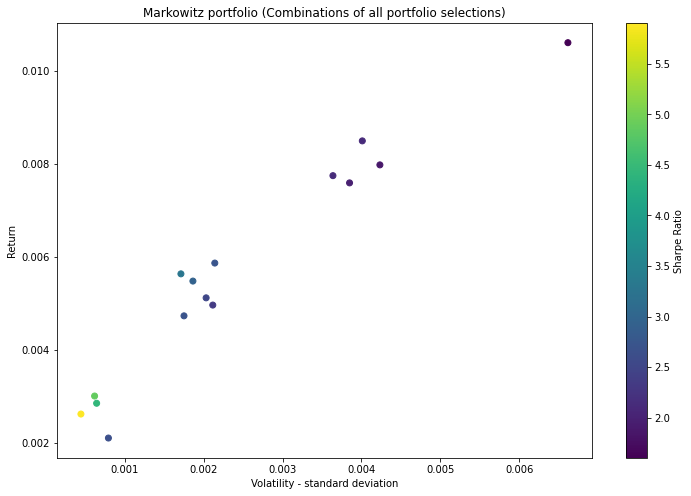

In [30]:
quantum_portfolio_plot(pdf)

## Get the operator for Qiskit portfolio model

In [31]:
q = 5.0                   # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

### Building the quibit operator.
qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

In [32]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
        
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))
        
# Function to convert   
def listToString(s):  
    # initialize an empty string 
    str1 = ""  
    # traverse in the string   
    for ele in s:  
        str1 += str(ele)   
    # return string   
    return str1
        
def get_results_list(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    expected_value = portfolio.portfolio_expected_value(selection, mu)
    print(expected_value)
    expected_variance = portfolio.portfolio_variance(selection, sigma)
    print(expected_variance)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
        
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    output = {}
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        output[listToString(x)] = probabilities[i]*1000.
    return output

def get_vqe_solutions(q_max, mu, sigma, budget, penalty):
    q_range = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000];
    solutions = [];
    #Backend
    backend = Aer.get_backend('statevector_simulator')
    # Cobyla
    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    for q in q_range:
        solution = get_vqe_solution(q, mu, sigma, budget, penalty, backend, cobyla)
        solutions.append(solution)
    df = pd.DataFrame.from_records(solutions)
    df.columns = ['Selection','Risk appetite', 'Value', 'Expected return', 'Volatility']
    return df

def get_vqe_solution(q, mu, sigma, budget, penalty, backend, cobyla):

    ### Building the quibit operator.
    qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
    
    # Optimizer.
    seed = 50
    # RY
    ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=9, entanglement='full')
    vqe = VQE(qubitOp, ry, cobyla)
    vqe.random_seed = seed
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    # Run
    result = vqe.run(quantum_instance)
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    expected_value = portfolio.portfolio_expected_value(selection, mu)
    expected_variance = portfolio.portfolio_variance(selection, sigma)
    
    return [selection, q, value, expected_value, expected_variance]
    

In [33]:
vqe_results = get_vqe_solutions(q, mu, sigma, budget, penalty)

In [34]:
vqe_results.head(20)

,Selection,Risk appetite,Value,Expected return,Volatility
0,"[0.0, 1.0, 1.0, 0.0]",0.00,-0.005869,0.005869,0.002141
1,"[1.0, 0.0, 1.0, 0.0]",0.01,-0.004945,0.004966,0.002116
2,"[0.0, 1.0, 0.0, 1.0]",0.10,-0.005466,0.005637,0.001712
3,"[0.0, 0.0, 1.0, 1.0]",1.00,-0.003618,0.005482,0.001864
4,"[0.0, 0.0, 1.0, 1.0]",10.00,0.013157,0.005482,0.001864
5,"[1.0, 1.0, 0.0, 0.0]",100.00,0.198011,0.005122,0.002031
6,"[1.0, 0.0, 0.0, 1.0]",1000.00,1.746129,0.004735,0.001751
7,"[0.0, 0.0, 0.0, 1.0]",10000.00,8.443835,0.002625,0.000445
8,"[0.0, 0.0, 0.0, 0.0]",100000.00,16.000000,0.000000,0.000000
9,"[0.0, 0.0, 0.0, 0.0]",100000.00,16.000000,0.000000,0.000000


In [49]:
def get_selection(solution):
        result = []
        for selection in solution['Selection']:
            items = selection.tolist()
            str_item = []
            for item in items:
                str_item.append(str(item))
            result.append(' '.join(str_item))
        return result
get_selection(vqe_results)

['0.0 1.0 1.0 0.0',
 '1.0 0.0 1.0 0.0',
 '0.0 1.0 0.0 1.0',
 '0.0 0.0 1.0 1.0',
 '0.0 0.0 1.0 1.0',
 '1.0 1.0 0.0 0.0',
 '1.0 0.0 0.0 1.0',
 '0.0 0.0 0.0 1.0',
 '0.0 0.0 0.0 0.0',
 '0.0 0.0 0.0 0.0']

In [346]:
def quantum_portfolio_plot(pdf, vqe_results):
    plt.figure(figsize=(12,8))
    plt.title('Markowitz portfolio (Combinations of all portfolio selections)')
    plt.scatter(pdf['Risk'], pdf['Returns'], c=pdf['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(vqe_results['Volatility'], vqe_results['Expected return'], c='red', s=50, marker="^")
    
    # zip joins x and y coordinates in pairs
    for x,y,text in zip(vqe_results['Volatility'],vqe_results['Expected return'],vqe_results['Selection']):
        print(text)
        
        label = '['
        for i in text:
            label += str(int(i))
        label += ']'
        
#         label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-5,3), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    
    plt.xlabel('Volatility - standard deviation')
    plt.ylabel('Return')
    plt.show()

[1. 1. 0. 0.]
[1. 0. 0. 1.]
[1. 0. 0. 1.]
[0. 1. 1. 0.]
[1. 0. 0. 1.]
[1. 0. 0. 1.]
[1. 0. 0. 1.]
[0. 0. 0. 1.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]


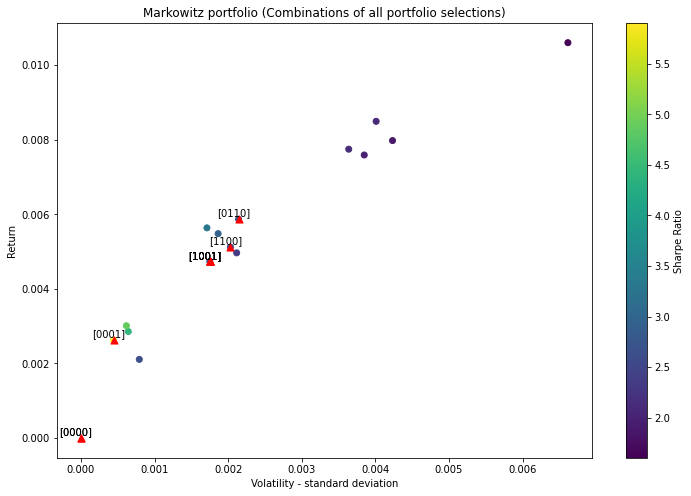

In [347]:
quantum_portfolio_plot(pdf, vqe_results)

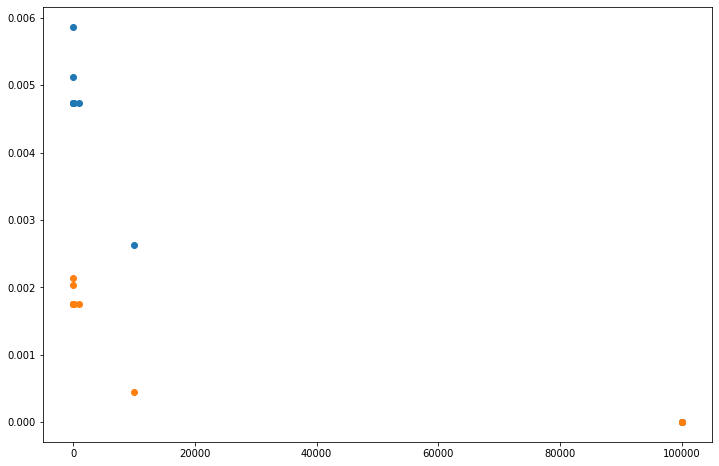

In [300]:
plt.figure(figsize=(12,8))
plt.scatter(vqe_results['Risk appetite'], vqe_results['Expected return'], cmap='viridis')
plt.scatter(vqe_results['Risk appetite'], vqe_results['Volatility'], cmap='viridis')

In [303]:
def get_vqe_solutions(q_max, mu, sigma, budget, penalty):
    q_range = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000];
    solutions = [];
    #Backend
    backend = Aer.get_backend('statevector_simulator')
    # Cobyla
    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    for q in q_range:
        solution = get_qaoa_solution(q, mu, sigma, budget, penalty, backend, cobyla)
        solutions.append(solution)
    df = pd.DataFrame.from_records(solutions)
    df.columns = ['Selection','Risk appetite', 'Value', 'Expected return', 'Volatility']
    return df

def get_qaoa_solution(q, mu, sigma, budget, penalty, backend, cobyla):
    ### Building the quibit operator.
    qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
    
    backend = Aer.get_backend('statevector_simulator')
    seed = 50

    qaoa = QAOA(qubitOp, cobyla, 1)
    qaoa.random_seed = seed
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

    result = qaoa.run(quantum_instance)

    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    expected_value = portfolio.portfolio_expected_value(selection, mu)
    expected_variance = portfolio.portfolio_variance(selection, sigma)
    
    return [selection, q, value, expected_value, expected_variance]

In [304]:
qaoa_results = get_vqe_solutions(q, mu, sigma, budget, penalty)

In [305]:
vqe_results.head(20)

,Selection,Risk appetite,Value,Expected return,Volatility
0,"[1.0, 1.0, 0.0, 0.0]",0.00,-0.005122,0.005122,0.002031
1,"[1.0, 0.0, 0.0, 1.0]",0.01,-0.004717,0.004735,0.001751
2,"[1.0, 0.0, 0.0, 1.0]",0.10,-0.004560,0.004735,0.001751
3,"[0.0, 1.0, 1.0, 0.0]",1.00,-0.003727,0.005869,0.002141
4,"[1.0, 0.0, 0.0, 1.0]",10.00,0.012774,0.004735,0.001751
5,"[1.0, 0.0, 0.0, 1.0]",100.00,0.170352,0.004735,0.001751
6,"[1.0, 0.0, 0.0, 1.0]",1000.00,1.746129,0.004735,0.001751
7,"[0.0, 0.0, 0.0, 1.0]",10000.00,8.443835,0.002625,0.000445
8,"[0.0, 0.0, 0.0, 0.0]",100000.00,16.000000,0.000000,0.000000
9,"[0.0, 0.0, 0.0, 0.0]",100000.00,16.000000,0.000000,0.000000


[0. 1. 1. 0.]
[0. 1. 1. 0.]
[0. 1. 1. 0.]
[0. 1. 0. 1.]
[0. 1. 0. 1.]
[1. 0. 1. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]


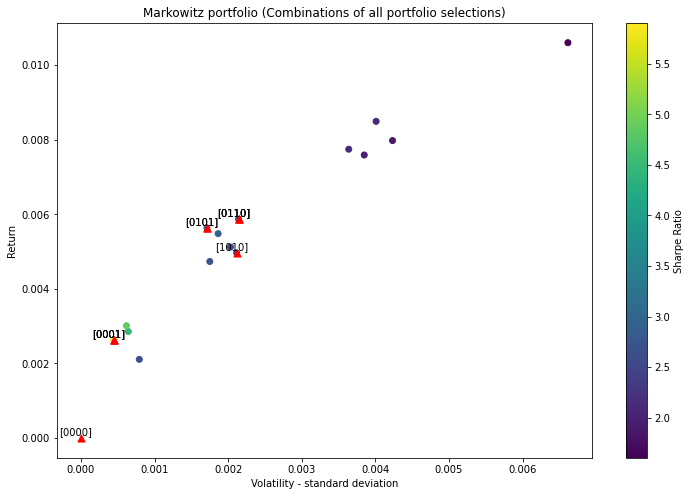

In [348]:
quantum_portfolio_plot(pdf, qaoa_results)

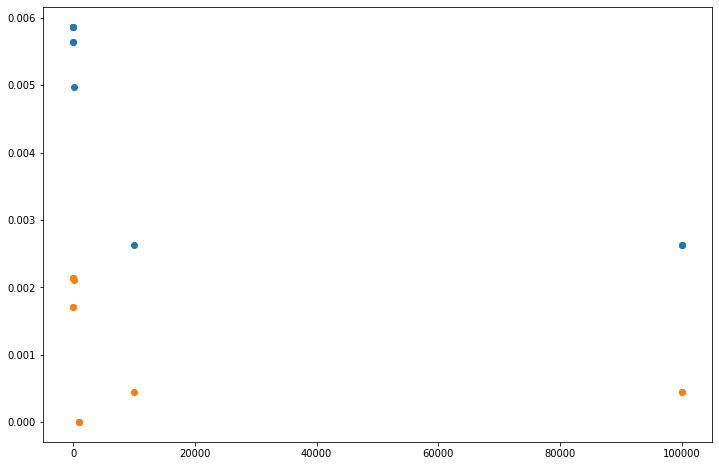

In [309]:
plt.figure(figsize=(12,8))
plt.scatter(qaoa_results['Risk appetite'], qaoa_results['Expected return'], cmap='viridis')
plt.scatter(qaoa_results['Risk appetite'], qaoa_results['Volatility'], cmap='viridis')

## Exact solution

Optimal: selection [0 1 0 1], value 0.0029

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	0.0029		1.0000
 [1 1 1 1]	16.0225		0.0000
 [0 1 1 1]	4.0116		0.0000
 [1 0 1 1]	4.0117		0.0000
 [0 0 1 1]	0.0038		0.0000
 [1 1 0 1]	4.0104		0.0000
 [1 0 0 1]	0.0040		0.0000
 [0 0 0 1]	3.9996		0.0000
 [1 1 1 0]	4.0132		0.0000
 [0 1 1 0]	0.0048		0.0000
 [1 0 1 0]	0.0056		0.0000
 [0 0 1 0]	4.0004		0.0000
 [1 1 0 0]	0.0050		0.0000
 [0 1 0 0]	4.0001		0.0000
 [1 0 0 0]	4.0019		0.0000
 [0 0 0 0]	16.0000		0.0000
0.005637097868250326
0.001711888729078744
Optimal: selection [0 1 0 1], value 0.0029


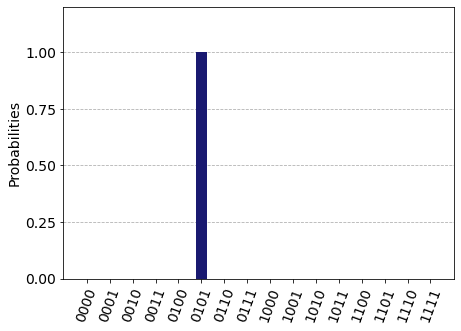

In [285]:
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)
out = get_results_list(result)
plot_histogram(data=out, color='midnightblue', bar_labels = False)

## VQE solution

Optimal: selection [0. 1. 0. 1.], value 0.0029

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	0.0029		0.6638
 [1 1 0 0]	0.0050		0.2293
 [1 0 0 1]	0.0040		0.0409
 [1 0 1 0]	0.0056		0.0397
 [0 1 1 0]	0.0048		0.0164
 [0 0 1 1]	0.0038		0.0097
 [1 1 1 0]	4.0132		0.0000
 [0 0 1 0]	4.0004		0.0000
 [0 1 0 0]	4.0001		0.0000
 [1 1 1 1]	16.0225		0.0000
 [0 1 1 1]	4.0116		0.0000
 [1 0 1 1]	4.0117		0.0000
 [0 0 0 1]	3.9996		0.0000
 [1 0 0 0]	4.0019		0.0000
 [1 1 0 1]	4.0104		0.0000
 [0 0 0 0]	16.0000		0.0000
0.005637097868250326
0.001711888729078744
Optimal: selection [0. 1. 0. 1.], value 0.0029


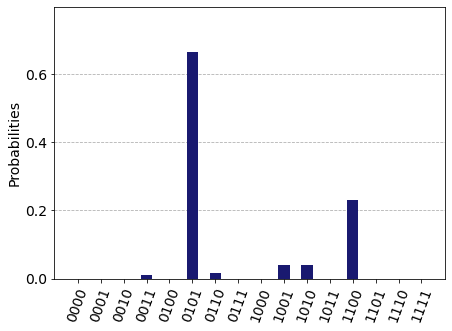

In [286]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=9, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)
out = get_results_list(result)
plot_histogram(data=out, color='midnightblue', bar_labels = False)


## QAOA Solution

Optimal: selection [0. 1. 0. 1.], value 0.0029

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	0.0029		0.1232
 [0 0 1 1]	0.0038		0.1232
 [1 0 0 1]	0.0040		0.1232
 [0 1 1 0]	0.0048		0.1231
 [1 1 0 0]	0.0050		0.1231
 [1 0 1 0]	0.0056		0.1231
 [0 0 1 0]	4.0004		0.0315
 [0 1 0 0]	4.0001		0.0315
 [0 0 0 1]	3.9996		0.0315
 [1 0 0 0]	4.0019		0.0314
 [1 1 0 1]	4.0104		0.0304
 [1 0 1 1]	4.0117		0.0304
 [0 1 1 1]	4.0116		0.0304
 [1 1 1 0]	4.0132		0.0303
 [1 1 1 1]	16.0225		0.0070
 [0 0 0 0]	16.0000		0.0068
0.005637097868250326
0.001711888729078744
Optimal: selection [0. 1. 0. 1.], value 0.0029


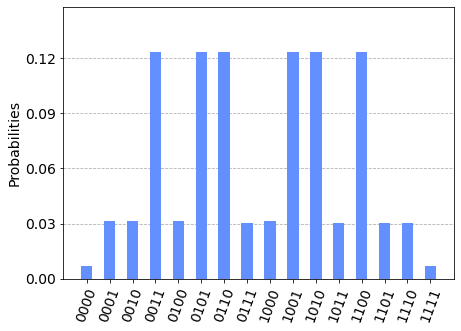

In [287]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 1)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)
out = get_results_list(result)
plot_histogram(data=out, bar_labels = False)

In [288]:
IBMQ.load_account()
provider = IBMQ.get_provider()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (num_assets) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

/Users/dhadi/opt/anaconda3/envs/qc/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_lima


In [289]:
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)
job_monitor(result)

print_result(result)

FAILURE: job id: 605d72222fc740eac6ba7797, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/605d72222fc740eac6ba7797/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x7ffe3a890fa0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'
FAILURE: job id: 605d72222fc740eac6ba7797, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/605d72222fc740eac6ba7797/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x7ffe3cd32b80>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'
FAILURE: job id: 605d72222fc740eac6ba7797, status: 'FA

KeyboardInterrupt: 

In [29]:
S = [1, 0, 1, 0]
Z = [1, -1, 1, 1]
I = 1
Result = (1.0*I - (0.5*I + 0.5*Z[0])*(0.5*I + 0.5*Z[1]) + 0.5*Z[0] + 0.5*Z[1])*(1.0*I - (0.5*I + 0.5*Z[2])*(0.5*I + 0.5*Z[3]) + 0.5*Z[2] + 0.5*Z[3])

In [30]:
print(Result)

1.0


In [21]:
Z = [-1, -1]
RE = 1.0*I - (0.5*I - 0.5*Z[0])*(0.5*I - 0.5*Z[1]) - 0.5*Z[0] - 0.5*Z[1]
print(RE)

1.0
